In [2]:
import mesa

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import rasterio
import math
import tqdm

In [3]:
# Read the tif file with DEM data
dem_file = "data/UK_DEM.tif"
dem_image = Image.open(dem_file)

# store the dem data into array
dem_array_big = np.array(dem_image)

In [4]:
# get a small area
# form (1000-1200, 1000-1200)

dem_array_small = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        dem_array_small[i][j] = dem_array_big[i+900][j+1000]

# dem_array_small.shape
dem_array = dem_array_small

In [4]:
# Draw dem_array_big
# plt.imshow(dem_array_big, cmap='gray')  
# plt.colorbar()  
# plt.title('Whole Area') 
# plt.xlabel('X Axis') 
# plt.ylabel('Y Axis')  
# plt.show() 

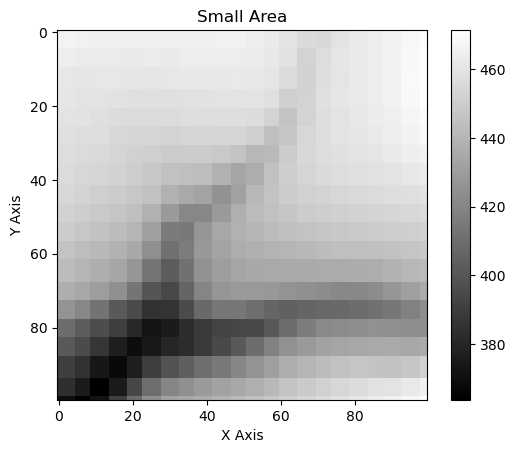

In [5]:
# Draw dem_array
plt.imshow(dem_array, cmap='gray')  
plt.colorbar()  
plt.title('Small Area') 
plt.xlabel('X Axis') 
plt.ylabel('Y Axis')  
plt.show() 

In [6]:
# Obtain geographic resolution information
with rasterio.open(dem_file) as src:
    x_resolution = src.transform[0]
    y_resolution = src.transform[4]
    # The average of the x and y directions is taken as the geographic resolution of the pixel
    pixel_resolution = (abs(x_resolution) + abs(y_resolution)) / 2.0
    print("Each pixel of the DEM equals [" + str(pixel_resolution) + "m] in the real world")

Each pixel of the DEM equals [10.0m] in the real world


In [7]:
# Variable definition
T = 25    # Average temperature
h = 0.6   # Relative humidity
dt = 5    # Time cost in each step

# Variable will change when model runs
s = pixel_resolution    # Length of the patch side in real world
h_i = 0   # Elevation of patch i
h_i1 = 0  # Elevation of patch i+1

In [8]:
# Constant definition
a = 0.03
c = 0.05
D = -0.3

In [9]:
# Definition of spread rate
R_0 = a*T + c*h - D   # Flat, windless, homogeneous burning speed

# Constant definition 
K_s = 1  # Combustibles coefficient, which indicates the effect of combustibles on the progress of combustion.
K_w = 1  # The wind direction coefficient, which indicates the effect of windiness and wind direction on the progress of combustion. In this paper the effect of wind is not considered.



K_phi = 1 # Slope factor, which indicates the effect of elevation difference on the burning progress.
K_phi_4 = math.exp(3.533 * pow( (abs(h_i-h_i1) / s ), 1.2))                      # Slope factor, calculation formula in the four-neighborhood domain
K_phi_8 = math.exp(3.533 * pow( (abs(h_i-h_i1) / (math.sqrt(2)*s)), 1.2))        # Slope factor, calculation formula in the eight-neighborhood diagonal

# Definition of integrated propagation speed
R = R_0 * K_s * K_w * K_phi
R_4 = R_0 * K_s * K_w * K_phi_4   # spread in the four-neighborhood domain
R_8 = R_0 * K_s * K_w * K_phi_8   # spread in the eight-neighborhood diagonal


In [25]:
class PatchAgent(mesa.Agent):
    def __init__(self, pos, unique_id, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.grid = model.grid
        self.elevation = None
        self.state = 0  # 0 means no combustion; 0-1 means incomplete combustion; 2 means complete combustion; 3 means extinguished
        self.affected = False
        self.isBoundary = False
        self.extinguished = False
        self.check_boundary()

    # agent do in each step
    def step(self):
        # Check affected?
        self.check_affected()
        # self.report_state()
        

    def advance(self):  
        self.update_state()
        self.affected = False
        self.regularize_state()       
        # self.report_state()
    
    # Definition of an agent's behavior
    # Check if it has been affected by its neighbour, update its state
    def check_affected(self):
        for each in self.grid.get_neighbors(self.pos, moore=True, include_center=False):
            if each.state == 1 or each.state == 2:
                self.affected = True
                # print("I'm affected at " + str(self.pos) + "\n My State is " + str(self.state))
    
    # report state if state is not 0
    def report_state(self):
        if self.state!=0:
            print(str(self.pos)+" report state: " + str(self.state))

    # Update the state value if affected
    def update_state(self):
        if self.affected and not(self.isBoundary):
            self.state = self.state + self.get_R_summary(4) + self.get_R_summary(8)  
            # print the log
            # print("I'm update at " + str(self.pos) + "\n My new State is " + str(self.state))
        return
    
    # Check if it is boundary, update its state
    def check_boundary(self):
        if self.pos[0] in (0, 1885, 1934) or self.pos[1] in (0, 1885, 1934):
            self.isBoundary = True
    
    # Regularized the state
    def regularize_state(self):
        # If itself is already extinguished, it returns directly
        if self.extinguished:
            return
        
        # Update status values based on status values
        if self.state >= 0 and self.state<1: # if its burning or not, stay the same situation 
            self.state = self.state
            return
        elif self.state>=1 and self.state!=3:  # if its burning well more than 1 and its not 3, change the state to 2
            self.state = 2
            return
        elif self.state==3:
            self.state = 3
            return
        else:
            # check extinguished?
            state_list = []
            for each in self.grid.get_neighbors(self.pos, moore=True, include_center=False):
                state_list.append(each.state)
            if all(x == 2 or x == 3 for x in state_list):
                self.state = 3
                self.extinguished = True
            
                 

    # get the single R, self as point1
    def get_R(self, x2, y2, mode = 4):
        elevation_1 = self.elevation
        
        # only the neighbour's state 2 can affect the center
        if self.grid[x2][y2].state!=2:
            return 0
        
        if mode == 4:
            elevation_2 = self.grid[x2][y2].elevation
            R_4_value = R_0 * K_s * K_w * math.exp(3.533 * pow( (abs(elevation_1-elevation_2) / s ), 1.2))
            return R_4_value
        elif mode == 8:
            elevation_2 = self.grid[x2][y2].elevation
            R_8_value = R_0 * K_s * K_w * math.exp(3.533 * pow( (abs(elevation_1-elevation_2) / (math.sqrt(2)*s)), 1.2))
            return R_8_value
        else:
            print("get_R: Worng mode! please check the input")

    # get the result of sum R, self as point1
    def get_R_summary(self, mode = 4):
        x = self.pos[0]
        y = self.pos[1]

        if mode == 4:
            R_4_summary_value = (self.get_R(x+1, y, 4) + \
                                 self.get_R(x-1, y, 4) + \
                                 self.get_R(x, y+1, 4) + \
                                 self.get_R(x, y-1, 4))*dt/s
            return R_4_summary_value
        elif mode == 8:
            R_8_summary_value = (math.pow(self.get_R(x+1, y+1, 8), 2) + \
                                 math.pow(self.get_R(x+1, y-1, 8), 2) + \
                                 math.pow(self.get_R(x-1, y+1, 8), 2) + \
                                 math.pow(self.get_R(x-1, y-1, 8), 2)) * dt \
                                 / (2*math.pow(s,2))
            return R_8_summary_value
        else:
            print("get_R_summary: Worng mode! please check the input")


In [26]:
class WorldModel(mesa.Model):
    def __init__(self):
        self.height = dem_array.shape[0]
        self.width = dem_array.shape[1]
        super().__init__(self.width, self.height, False)
        self.grid = mesa.space.SingleGrid(self.width, self.height, False)
        self.ini_id = 0
        self.schedule = mesa.time.SimultaneousActivation(self)

        for x in range(self.width):
            for y in range(self.height):
                elevation = dem_array[y ,x]
                self.patchAgent = PatchAgent(pos= (x,y),unique_id= self.ini_id, model= self)
                self.patchAgent.elevation = elevation
                self.schedule.add(self.patchAgent)
                self.grid.place_agent(self.patchAgent, (x,y))
                self.ini_id = self.ini_id + 1
        self.set_fire(50,50)
        # self.get_agent_counts()
    
    # each step what will happen?
    def step(self):
        self.schedule.step()



    # set a fire at XY
    def set_fire(self, x, y):
        fire_patch = self.grid[x][y]
        fire_patch.state = 2
        print("Well done, you set up a fire at " + str(fire_patch.pos))



In [27]:
# 建立测试模型， 花费时间10s 
# test = WorldModel()

Well done, you set up a fire at (50, 50)


In [28]:
# test.schedule.get_agent_count()

In [29]:
# for i in range(3):
#     print("Step: " + str(i))
#     test.step()

Step: 0
Step: 1
Step: 2


In [34]:
def forest_draw(agent):
    agent_portrayal_green = {
        "Shape" : "circle",
        "Filled": "true",
        "Layer": 0,
        "Color": "green",
        "r": 1
    }
    agent_portrayal_red = {
        "Shape" : "circle",
        "Filled": "true",
        "Layer": 0,
        "Color": "red",
        "r": agent.state
    }
    agent_portrayal_grey = {
        "Shape" : "circle",
        "Filled": "true",
        "Layer": 0,
        "Color": "grey",
        "r": 0.5
    }
        
    if agent.state == 0:
        return agent_portrayal_green
    elif agent.state>0 and agent.state!=3:
        return agent_portrayal_red
    elif agent.state==3:
        return agent_portrayal_grey

In [35]:
canvas_element = mesa.visualization.CanvasGrid(forest_draw, dem_array.shape[1], dem_array.shape[0], 500, 500)


In [36]:
server = mesa.visualization.ModularServer(WorldModel, [canvas_element], "Testing", {})

Well done, you set up a fire at (50, 50)


In [37]:
server.launch(port=7737)

Interface starting at http://127.0.0.1:7737


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
Well done, you set up a fire at (50, 50)
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type